
![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)
## Project 4: Web Scraping Job Postings
#### NoteBook 3 - Part1 and Part2
## Submitted by Roshan Lulu

## Part 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds such as the median salary.

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key.

Note that most listings *DO NOT* come with salary information. Being to able extrapolate or predict the expected salaries for other listings is exactly why this model will be so valuable.

**Steps for Part 1:**

1. Collect data from [Indeed.com](www.indeed.com) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
  - Select and parse data from at least 1000 postings for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (Title, location, department, etc.).
  - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
  - Your Boss is interested in what overall features hold the greatest significance.
  - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.  
4. Author a report to your Principal detailing your analysis.

### Part 0: Read in cleaned dataframe to proceed with questions 1 and 2

In [809]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [810]:
import re

In [811]:
import warnings
warnings.filterwarnings('ignore')

#### Read the data

In [812]:
# Savecleaned dataframe to a csv file
all_jobpost = './database/all_jobpost_cleaned_data.csv'
valid_salary_jobpost = './database/valid_jobpost_cleaned_data.csv'
valid_salary_jobpost_text = './database/valid_jobpost_text_cleaned_data.csv'

In [813]:
# Read in all the job posts with and without Salary
data = pd.read_csv(all_jobpost)
# Read in all the job posts with a valid Salary(salary != 0)
data_valid_y = pd.read_csv(valid_salary_jobpost)
# Read in job posts with valid salary and the text frame passed through count vectorizer
data_w_text = pd.read_csv(valid_salary_jobpost_text)

In [814]:
# Checking the data frame is still intact when saved to a csv and read in!

In [815]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 9 columns):
Title_Code       2830 non-null int64
City_Code        2830 non-null int64
Region_Code      2830 non-null int64
Classif_Code     2830 non-null int64
WorkType_Code    2830 non-null int64
Adv_Code         2830 non-null int64
KeyJob_Code      2830 non-null int64
JobDescript      2785 non-null object
Salary           2830 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 199.1+ KB


In [816]:
#### The empty string seem to have been read in as null values ~45 of them
#### I will drop them for now

In [817]:
# data.dropna(subset = ['JobDescript'], axis = 0, inplace = True)
data.fillna('', inplace = True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 9 columns):
Title_Code       2830 non-null int64
City_Code        2830 non-null int64
Region_Code      2830 non-null int64
Classif_Code     2830 non-null int64
WorkType_Code    2830 non-null int64
Adv_Code         2830 non-null int64
KeyJob_Code      2830 non-null int64
JobDescript      2830 non-null object
Salary           2830 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 199.1+ KB


In [818]:
data_valid_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 9 columns):
Title_Code       724 non-null int64
City_Code        724 non-null int64
Region_Code      724 non-null int64
Classif_Code     724 non-null int64
WorkType_Code    724 non-null int64
Adv_Code         724 non-null int64
KeyJob_Code      724 non-null int64
JobDescript      719 non-null object
Salary           724 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 51.0+ KB


In [819]:
# data_valid_y.dropna(subset = ['JobDescript'], axis = 0, inplace = True)
data_valid_y.fillna('', inplace = True)
data_valid_y.reset_index(drop=True, inplace=True)
data_valid_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 9 columns):
Title_Code       724 non-null int64
City_Code        724 non-null int64
Region_Code      724 non-null int64
Classif_Code     724 non-null int64
WorkType_Code    724 non-null int64
Adv_Code         724 non-null int64
KeyJob_Code      724 non-null int64
JobDescript      724 non-null object
Salary           724 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 51.0+ KB


In [820]:
data_w_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Columns: 1009 entries, Title_Code to years experience
dtypes: float64(1), int64(1007), object(1)
memory usage: 5.6+ MB


##  A - Factors that impact Salary
Find out what factors most directly impact salaries (Title, location, department, etc.).
    - Test, validate, and describe your models. What factors predict salary category? How do your models perform?


### Approach :
Salary is a continuous variable. Hence, I choose a regression model. The no of valid salaries are a small proportion. So I choose to take a small training set and proceed with the regression to check the performance of the model.

In [821]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
# StandardScaler object
from sklearn.preprocessing import StandardScaler

# K-fold cross validation model
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [822]:
seek_data = data_valid_y[:]
seek_data.columns

Index(['Title_Code', 'City_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code', 'KeyJob_Code', 'JobDescript', 'Salary'],
      dtype='object')

In [823]:
predictors_target = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code', 'Salary']
seek_data = seek_data[predictors_target]

In [824]:
seek_data.shape

(724, 6)

#### My predictors are mostly categorical variables. I need convert them to dummy variables

In [825]:
target = ['Salary']
predictors = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code']

seek_data.head()

,Title_Code,Region_Code,Classif_Code,WorkType_Code,KeyJob_Code,Salary
0,5,0,0,0,1,180000.0
1,0,6,3,0,1,90000.0
2,1,6,0,0,1,14400.0
3,1,0,7,0,1,120000.0
4,1,0,1,0,1,160000.0


In [826]:
# Convert the categorical variables to dummies to proceed with linear regression
seek_data_dummies = pd.get_dummies(seek_data, drop_first = True, columns = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code'])

In [827]:
seek_data_dummies.head()

,Salary,Title_Code_1,Title_Code_2,Title_Code_3,Title_Code_4,Title_Code_5,Title_Code_6,Title_Code_7,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_16,Region_Code_18,Classif_Code_1,Classif_Code_2,Classif_Code_3,Classif_Code_4,Classif_Code_5,Classif_Code_6,Classif_Code_7,WorkType_Code_1,WorkType_Code_2,KeyJob_Code_1,KeyJob_Code_2,KeyJob_Code_3,KeyJob_Code_4
0,180000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,90000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,14400.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,120000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,160000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


### Trying to fit the model with statsmodel
- Model has an R2 of 0.243. meaning the predictors explain about 24.3% of the variance. It is not good enough for a prediction model

In [828]:
import statsmodels.api as sm
import patsy

In [829]:
# Prepare the list of Xs for the patsy formula
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
all_columns = "+".join(cols)

# Prepare the patsy format y~ Xs
my_formula = "Salary~" + all_columns

y, X = patsy.dmatrices(my_formula, data=seek_data_dummies, return_type='dataframe')

y = y.values.ravel()

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     6.345
Date:                Sat, 13 May 2017   Prob (F-statistic):           1.87e-24
Time:                        07:49:34   Log-Likelihood:                -8787.8
No. Observations:                 724   AIC:                         1.765e+04
Df Residuals:                     688   BIC:                         1.781e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.587e+04   1.27e+04      6.767      0.000     6.1e+04    1.11e+05
Title_Code_1     3.103e+04   1.21e+04      2.570      0.010    7324.232    5.47e+04
Title_Code_2     5.212e+04   1.26e+04      4.131      0.000    2.73e+04    7.69e+04
Title_Code_3     4.065e+04   1.35e+04      3.004      0.003    1.41e+04    6.72e+04
Title_Code_4     5.401e+04   1.62e+04      3.335      0.001    2.22e+04    8.58e+04
Title_Code_5     6.382e+04   1.33e+04      4.786      0.000    3.76e+04       9e+04
Title_Code_6     9.441e+04   4.85e+04      1.946      0.052    -854.370     1.9e+05
Title_Code_7     8.034e+04   1.61e+04      4.982      0.000    4.87e+04    1.12e+05
Region_Code_1    4934.9017   8212.720      0.601      0.548   -1.12e+04    2.11e+04
Region_Code_2     298.7362   1.04e+04      0.029      0.977      -2e+04    2.06e+04
Region_Code_3    -1.01e+04   9800.361     -1.031      0.303   -2.93e+04    9140.661
Region_Code_4   -3.165e+04   1.39e+04     -2.276      0.023    -5.9e+04   -4347.983
Region_Code_5   -3.824e+04   3.34e+04     -1.145      0.253   -1.04e+05    2.73e+04
Region_Code_6   -2108.4354   8294.352     -0.254      0.799   -1.84e+04    1.42e+04
Region_Code_7   -1.578e+04   4897.235     -3.221      0.001   -2.54e+04   -6160.673
Region_Code_8   -2.754e+04   1.41e+04     -1.960      0.050   -5.51e+04      54.078
Region_Code_9   -6.959e+04      2e+04     -3.485      0.001   -1.09e+05   -3.04e+04
Region_Code_10  -4.648e+04   2.83e+04     -1.644      0.101   -1.02e+05    9027.142
Region_Code_12    678.2297   1.03e+04      0.066      0.948   -1.96e+04    2.09e+04
Region_Code_13  -2.205e+04   7245.966     -3.043      0.002   -3.63e+04   -7821.301
Region_Code_14  -2.743e+04   3.32e+04     -0.826      0.409   -9.27e+04    3.78e+04
Region_Code_16  -7.654e+04   4.67e+04     -1.640      0.102   -1.68e+05    1.51e+04
Region_Code_18  -2.184e+04    1.7e+04     -1.284      0.200   -5.52e+04    1.16e+04
Classif_Code_1   -437.8722   1.32e+04     -0.033      0.974   -2.64e+04    2.55e+04
Classif_Code_2  -8047.8144   5169.857     -1.557      0.120   -1.82e+04    2102.775
Classif_Code_3  -7642.4152   8272.100     -0.924      0.356   -2.39e+04    8599.174
Classif_Code_4  -2.927e+04   9398.739     -3.114      0.002   -4.77e+04   -1.08e+04
Classif_Code_5  -1.699e+04   1.35e+04     -1.263      0.207   -4.34e+04    9429.685
Classif_Code_6  -2.654e+04   2.84e+04     -0.936      0.350   -8.22e+04    2.92e+04
Classif_Code_7  -1.696e+04   7092.029     -2.391      0.017   -3.09e+04   -3035.769
WorkType_Code_1  3.562e+04   4001.952      8.900      0.000    2.78e+04    4.35e+04
WorkType_Code_2  7157.3301   2.43e+04      0.295      0.768   -4.05e+04    5.48e+04
KeyJob_Code_1    1.422e+04   1.01e+04      1.409      0.159   -5590.396     3.4e+04
KeyJob_Code_2    3598.9792    1.5e+04      0.240      0.810

#### Split the data --> 60-40 , Test-Train Split 

In [830]:
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
X = seek_data_dummies[cols]
y = seek_data_dummies['Salary']

In [831]:
from sklearn.model_selection import train_test_split

In [832]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(434, 35) (434,)
(290, 35) (290,)


#### Fitting with Linear Regression Model 

In [833]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [834]:
print (slr.score(X_train, y_train))

0.271749886223


In [835]:
print (slr.score(X_test, y_test))

-1.7550737998e+23


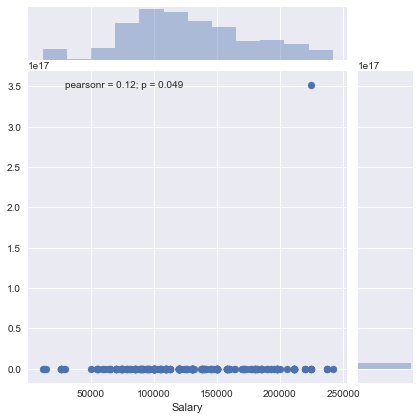

In [836]:
yhat = slr.predict(X_test)
sns.jointplot(y_test, yhat)
plt.show()

- I tried with different test train split[70/30,20/80 ] making the training set slightly larger to check if I was getting better results. But the score remained always in the range of 0.2 - 0.3
- The model is bad, Id still like to check the cross validation results

#### K-fold Cross validation

In [837]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 5-fold cross validation
scores = cross_val_score(slr, X, y, cv=5)
print ("Cross-validated scores:", scores)

# Make cross validated predictions on the test sets
predictions = cross_val_predict(slr, X, y, cv=5)
plt.scatter(y, predictions)

# manually calcualte the r2
r2 = metrics.r2_score(y, predictions)
print ("Cross-Predicted R2:", r2)


Cross-validated scores: [ -6.64940381e+25  -1.98962850e-02   2.01832890e-01   1.35828805e-01
  -8.39057914e-02]
Cross-Predicted R2: -1.07161977853e+25


- That is a pretty bad score for the Linear regression model using all the categorical features.
- Let me try some regularization methods to find better predictors
    - Before any regularization, Standardize predictors! 

#### Regularization techniques

In [838]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

In [839]:
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
X = seek_data_dummies[cols]
y = seek_data_dummies['Salary']

In [840]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs = ss.fit_transform(X)

In [841]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print(linreg_scores)
print(np.mean(linreg_scores))

[ -3.74626824e+23   2.63537677e-01   1.31422327e-01  -1.20666171e+00
   2.83703113e-01   1.19743922e-01   1.93432706e-01   1.45434942e-01
  -7.56249471e-02  -1.28907988e+23]
-5.03534812014e+22


- R2 is negative for the Linear regression model with all Xs as predictors. That is obviously not a good one.

#### Ridge

In [842]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

172.25859654


In [843]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[ 0.04652803  0.2391155   0.12579089  0.11950477  0.23976208  0.13818175
  0.18527129  0.10543794  0.11144597 -0.11561746]
0.119542076583


#### The ridge scores are better than the linear regression, but its not good enough

#### Lasso

In [844]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print (optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

609.526820119


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


#### Cross validating lasso R2 with optimal alpha

In [845]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[ 0.05911877  0.25156334  0.12890325  0.11416707  0.2693359   0.14457985
  0.20374775  0.12061623 -0.00703061 -0.2253775 ]
0.105962404527


In [846]:
lasso.fit(Xs, y)

Lasso(alpha=609.52682011862896, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [847]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_best = list(lasso_coefs.variable.head().values)
lasso_coefs = lasso_coefs[lasso_coefs['abs_coef'] > 0]
lasso_coefs

,abs_coef,coef,variable
29,16481.701684,16481.701684,WorkType_Code_1
4,8723.756756,8723.756756,Title_Code_5
6,7350.493285,7350.493285,Title_Code_7
1,7041.013345,7041.013345,Title_Code_2
15,5537.993620,-5537.993620,Region_Code_9
13,5039.646781,-5039.646781,Region_Code_7
25,4867.434820,-4867.434820,Classif_Code_4
18,4306.363582,-4306.363582,Region_Code_13
28,3498.376073,-3498.376073,Classif_Code_7
10,3421.761157,-3421.761157,Region_Code_4


In [848]:
print ('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

Percent variables zeroed out: 0.00966850828729


- R2 doesnt improve much using Lasso. Still ~0.1 :(

#### Elastic net

In [849]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs, y)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

636.2622652
1.0


In [850]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print (enet_scores)
print (np.mean(enet_scores))

[ 0.05607325  0.2505531   0.12854612  0.11233691  0.26872003  0.145265
  0.20389355  0.12088399 -0.00348293 -0.2233945 ]
0.10593945238


- Again no change in R2.
- In the search for a better performing model, next I'm going to try Feature selection methods like kbext and compare it with results from lasso best found above.

#### Feature selection - Kbest

In [851]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

# train the selector on our data
skb_f.fit(X, y)
# skb_chi2.fit(X, y)

# examine results
kbest = pd.DataFrame([cols, list(skb_f.scores_)], 
                     index=['feature','f_classif']).T.sort_values('f_classif', ascending=False)
kbest.head()

,feature,f_classif
6,Title_Code_7,16.1258
29,WorkType_Code_1,14.7309
30,WorkType_Code_2,12.4008
26,Classif_Code_5,9.0294
15,Region_Code_9,5.81848


In [852]:
kbest_features = list(kbest.feature.head(4).values)
(kbest_features)

['Title_Code_7', 'WorkType_Code_1', 'WorkType_Code_2', 'Classif_Code_5']

In [853]:
X_kbest = seek_data_dummies[kbest_features]
X_lasso = seek_data_dummies[lasso_best]
y = seek_data_dummies['Salary']

In [854]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
Xs_kbest = ss.fit_transform(X_kbest)
Xs_lasso = ss.fit_transform(X_lasso)

In [855]:

linreg = LinearRegression()

linreg_scores_kbest = cross_val_score(linreg, Xs_kbest, y, cv=10)
linreg_scores_lasso = cross_val_score(linreg, Xs_lasso, y, cv=10)

print('Kbest Scores')
print(linreg_scores_kbest)
print(np.mean(linreg_scores_kbest))

print('Lasso Scores')
print(linreg_scores_lasso)
print(np.mean(linreg_scores_lasso))

Kbest Scores
[-0.01179361  0.04754624  0.08569187  0.06914491  0.20021313  0.13931363
  0.09503082  0.05216329  0.09557312 -0.33388837]
0.0438995022052
Lasso Scores
[ 0.12934724  0.16902629  0.07093878 -0.0803449   0.26264122  0.13732835
  0.1762234   0.14627158  0.08408168 -0.1507385 ]
0.094477512907


- The scores are not getting any better !
- I would like to check if it is possible to minimize the loss function

#### Gradient Descent

In [856]:
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV

In [857]:
# Prepare the list of Xs for the patsy formula
cols = list(seek_data_dummies.columns)
cols.remove('Salary')
all_columns = "+".join(cols)

X = patsy.dmatrix(all_columns, data=seek_data_dummies, return_type='dataframe')

y = seek_data_dummies.Salary.values
ss = StandardScaler()
Xs = ss.fit_transform(X)
print (y.shape, Xs.shape)

(724,) (724, 36)


In [858]:
# set up my gridsearch parameters:
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2','elasticnet'],
    'alpha':np.logspace(-5,1,25)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=1)

In [859]:
# SGD is pretty fast compared to other sklearn solvers - but can still
# take a good long while depending on the gridsearch and the size of
# the dataset.
sgd_reg_gs.fit(Xs, y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    1.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ['squared_loss', 'huber'], 'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': array([  1.00000e-05,   1.77828e-05,   3.16228e-05,   5.62341e-05,
         1.00000e-04,   1.77828e-04,   3.16228e-04,   5.62341e-04,
         1.00000e-03,   1.77828e-03,   3.16228e-03,   5.62341e-03,
    ...2341e-01,
         1.00000e+00,   1.77828e+00,   3.16228e+00,   5.62341e+00,
         1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [860]:
print (sgd_reg_gs.best_params_)
print (sgd_reg_gs.best_score_)
sgd_reg = sgd_reg_gs.best_estimator_

{'alpha': 1.0, 'loss': 'squared_loss', 'penalty': 'l2'}
0.0911248577740685


### Infer:
    - The Linear Regression is not a good model for predicting the salary. It could be because of the less valid salaries that were available.
    - How to make the model better:
        - Try vectorizing the words and add them as features. 
        - Get more valid salary data

### B. Discover which features have the greatest importance when determining a low vs. high paying job.
- Your Boss is interested in what overall features hold the greatest significance.
- HR is interested in which SKILLS and KEY WORDS hold the greatest significance.  

### Approach
    - In order to get the overall features/SKILLS/Keywords that are significant, the target is not the continuous salary anymore.
    - Add a new target that will be 0/1 based on low paying vs high paying jobs!
    - This now becomes a classification problem.
    - What features are good to determine the new target low/high pay jobs!
    - Can I use CARTS/ KNN / LogisticRegressionCV/PCA
    - words that are significant to determine low/high pay jobs
    - Can I use PCA on all the keywords and skills?

In [861]:
# Copy the dataframe
class_data = data_valid_y[:]
class_data
#pick the feature columns
predictors = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code']
# Target is salary range. Currently Salary is a continuous variable. 
# Create the target feature to make Salary high/low or 1/0 paying jobs
class_data = class_data[['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code', 'Salary']]

#### Assumption: Salary > 120,000 per annum - High paying job
    - With the data I have, 120000 looks like the median. I chose this for better segregation of results

In [862]:
# Convert salary to a new feature
class_data['High_Pay'] = [1 if salary > 120000 else 0 for salary in class_data['Salary']]
# Check Distribution of Salary to find the median
print(class_data['High_Pay'].value_counts())

0    367
1    357
Name: High_Pay, dtype: int64


In [863]:
# Convert the categorical variables to dummies to proceed with linear regression
class_data_dummies = pd.get_dummies(class_data, drop_first = True, columns = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code'])

In [864]:
class_data_dummies.columns

Index(['Salary', 'High_Pay', 'Title_Code_1', 'Title_Code_2', 'Title_Code_3',
       'Title_Code_4', 'Title_Code_5', 'Title_Code_6', 'Title_Code_7',
       'Region_Code_1', 'Region_Code_2', 'Region_Code_3', 'Region_Code_4',
       'Region_Code_5', 'Region_Code_6', 'Region_Code_7', 'Region_Code_8',
       'Region_Code_9', 'Region_Code_10', 'Region_Code_12', 'Region_Code_13',
       'Region_Code_14', 'Region_Code_16', 'Region_Code_18', 'Classif_Code_1',
       'Classif_Code_2', 'Classif_Code_3', 'Classif_Code_4', 'Classif_Code_5',
       'Classif_Code_6', 'Classif_Code_7', 'WorkType_Code_1',
       'WorkType_Code_2', 'KeyJob_Code_1', 'KeyJob_Code_2', 'KeyJob_Code_3',
       'KeyJob_Code_4'],
      dtype='object')

In [865]:
predictors = list(class_data_dummies.columns)
predictors.remove('Salary')

In [866]:
predictors.remove('High_Pay')

In [867]:
# Create target and predictor data
X_cls = class_data_dummies[predictors]
y_cls = class_data_dummies['High_Pay'].values

In [868]:
# Cross validate regression and logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [869]:
cls_scores = cross_val_score(LogisticRegression(), X_cls, y_cls, cv=4)

print ('Classification/Logistic regression score:', cls_scores, np.mean(cls_scores))

logreg = LogisticRegression().fit(X_cls, y_cls)

Classification/Logistic regression score: [ 0.65934066  0.75690608  0.72375691  0.69444444] 0.708612021803


- As we saw earlier, the Linear regression model to predict the continuous salary did not work well. However, Classification model for High and low paying jobs is way better in terms of score. What I can be sur eof is that the linear regression did not work well because of the less amount of data points.

- The aim is to find features that contribute to identify the different classification groups. I will try using the Grid Search CV for the  Decision tree classifier

#### CARTS - Decision tree classifier

In [870]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [871]:
# Setting up the parameters for Gridsearch CV
# max-depth - Try expanding the nodes to  3,4 or none(where all nods are expanded to check for best option)
# max -features- Look for all the features at each split along with atleast 2,3 ,4,5 feature bunches
# min-samples-split - check a range of minimums amples and check the results. I will iteratively change if results are not as expected.

dtc_params = {
    'max_depth':[None,2,3,4],
    'max_features':[None,2,3,4,5],
    'min_samples_split':[2,3,4,5,6,7,8,9,15,20,25,30,40,50]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=6, verbose=1)

In [872]:
dtc_gs.fit(X_cls, y_cls)

Fitting 6 folds for each of 280 candidates, totalling 1680 fits


[Parallel(n_jobs=1)]: Done 1680 out of 1680 | elapsed:    4.1s finished


GridSearchCV(cv=6, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 2, 3, 4], 'max_features': [None, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [873]:
dtc_best = dtc_gs.best_estimator_
print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

{'max_depth': 3, 'max_features': None, 'min_samples_split': 2}
0.697513812155


In [874]:
# Get the features with the most importance from the GridSearch CV on the Decision Tree classifier
fi = pd.DataFrame({
        'feature':X_cls.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi = fi[fi.importance > 0]
fi

,feature,importance
29,WorkType_Code_1,0.531225
0,Title_Code_1,0.261969
4,Title_Code_5,0.059431
31,KeyJob_Code_1,0.052421
15,Region_Code_9,0.049007
14,Region_Code_8,0.045947


In [875]:
list(fi.feature)

['WorkType_Code_1',
 'Title_Code_1',
 'Title_Code_5',
 'KeyJob_Code_1',
 'Region_Code_9',
 'Region_Code_8']

#### Inference from Grid Search CV results
- Important important features for  determining a High vs low pay job
- The ['WorkType_Code_1',
 'Title_Code_1',
 'Title_Code_5',
 'KeyJob_Code_1',
 'Region_Code_9',
- Here Ive done the classification and regression from the geographical and other features of the Job posting. The description is something that could make a difference. Checking that out next..

In [876]:
## Repeating the GridSearch CV for getting the Key skills and words from the Job description

In [877]:
# Get the dataframe with valid salary and text extracted
data_w_text.shape

(724, 1009)

In [878]:
class_data = data_w_text[:]
class_data.head(2)

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary,12 months,12 months successful,13 january,13 january 2017,2010 cca,2010 cca additional,2010 regulatory,2010 regulatory instruments,2010 review,2010 review investigate,2017 months,2017 months automatically,400 words,ability work,accc aer,accc aer accc,accc aer called,accc aer functions,accc aer ii,accc aer responsibilities,accc aer seeking,accc aers,accc aers goals,accc aers work,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist,accc specialist legal,accc supported,accc supported staff,access accc,access accc specialist,accounting related,accounting related fields,act 2010,act 2010 cca,act 2010 regulatory,act 2010 review,ad hoc,additional legislation,additional legislation promoting,additional roles,additional roles review,additionally want,additionally want build,administrative undertakings,administrative undertakings court,advanced excel,advertised externally,advertised externally 13,advice range,advice range accc,advocating policy,advocating policy changes,aer accc,aer accc independent,aer board,aer board separate,aer called,aer called fulfil,aer functions,aer functions maintain,aer ii,aer ii technically,aer independent,aer independent body,aer responsibilities,aer responsibilities apply,aer seeking,aer seeking applications,aers goals,aers goals accc,aers work,aers work rapidly,aim recruitment,aim recruitment immediately,analyse assess,analyse assess distil,analysis consumer,analysis consumer protection,analysis data,analysis experience,analyst join,analyst role,analyst work,analytical skills,anti competitive,anti competitive conduct,applicant processes,applicant processes wish,application applicant,application applicant processes,applications authorisation,applications authorisation notification,applications people,applications people skills,applied job,applied job need,applied list,applied list liketo,applied process,applied process list,apply applying,apply button,apply click,apply maybe,apply maybe selection,apply online,apply online using,apply senior,apply senior people,apply today,apply tools,apply tools available,appoint people,appoint people specialist,appropriate link,aps classifications,aps classifications people,aps executive,aps executive level,areas location,areas location considered,arise 12,arise 12 months,arrangements conduct,arrangements conduct result,asked upload,asked upload resume,assess distil,assess distil key,assessing reviewing,assessing reviewing mergers,assessment automatically,assessment automatically included,au notes,au notes employment,australian economy,australian economy currently,australians aer,australians aer independent,australians candidates,australians candidates seeking,authorisation notification,authorisation notification certain,authority role,authority role enforce,automatically applied,automatically applied process,automatically included,automatically included let,available opportunity,available opportunity applied,available resolve,available resolve matters,awareness influence,awareness influence business,based information,based information evidence,behaviour apply,behaviour apply applying,benefit australians,benefit australians aer,benefit warrant,benefit warrant exemption,best practice,big data,board separate,board separate accc,body responsible,body responsible regulating,broad range,broad range groups,build list,build list qualified,build organisational,build organisational capability,building specialist,building specialist teams,business analysis,business analyst,business analyst join,business analysts,business behaviour,business behaviour apply,business design,business development,business intelligence,business needs,business partnering,business process,business processes,business requirements,business stakeholders,business systems,business units,business users,businesses iii,businesses iii tactical,ca cpa,called fulfil,called fulfil specifi

In [879]:
drop_cols = ['City_Code', 'Adv_Code', 'JobDescript']
class_data.drop(drop_cols, inplace = True, axis = 1)

In [880]:
class_data.head(2)

,Title_Code,Region_Code,Classif_Code,WorkType_Code,KeyJob_Code,Salary,12 months,12 months successful,13 january,13 january 2017,2010 cca,2010 cca additional,2010 regulatory,2010 regulatory instruments,2010 review,2010 review investigate,2017 months,2017 months automatically,400 words,ability work,accc aer,accc aer accc,accc aer called,accc aer functions,accc aer ii,accc aer responsibilities,accc aer seeking,accc aers,accc aers goals,accc aers work,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist,accc specialist legal,accc supported,accc supported staff,access accc,access accc specialist,accounting related,accounting related fields,act 2010,act 2010 cca,act 2010 regulatory,act 2010 review,ad hoc,additional legislation,additional legislation promoting,additional roles,additional roles review,additionally want,additionally want build,administrative undertakings,administrative undertakings court,advanced excel,advertised externally,advertised externally 13,advice range,advice range accc,advocating policy,advocating policy changes,aer accc,aer accc independent,aer board,aer board separate,aer called,aer called fulfil,aer functions,aer functions maintain,aer ii,aer ii technically,aer independent,aer independent body,aer responsibilities,aer responsibilities apply,aer seeking,aer seeking applications,aers goals,aers goals accc,aers work,aers work rapidly,aim recruitment,aim recruitment immediately,analyse assess,analyse assess distil,analysis consumer,analysis consumer protection,analysis data,analysis experience,analyst join,analyst role,analyst work,analytical skills,anti competitive,anti competitive conduct,applicant processes,applicant processes wish,application applicant,application applicant processes,applications authorisation,applications authorisation notification,applications people,applications people skills,applied job,applied job need,applied list,applied list liketo,applied process,applied process list,apply applying,apply button,apply click,apply maybe,apply maybe selection,apply online,apply online using,apply senior,apply senior people,apply today,apply tools,apply tools available,appoint people,appoint people specialist,appropriate link,aps classifications,aps classifications people,aps executive,aps executive level,areas location,areas location considered,arise 12,arise 12 months,arrangements conduct,arrangements conduct result,asked upload,asked upload resume,assess distil,assess distil key,assessing reviewing,assessing reviewing mergers,assessment automatically,assessment automatically included,au notes,au notes employment,australian economy,australian economy currently,australians aer,australians aer independent,australians candidates,australians candidates seeking,authorisation notification,authorisation notification certain,authority role,authority role enforce,automatically applied,automatically applied process,automatically included,automatically included let,available opportunity,available opportunity applied,available resolve,available resolve matters,awareness influence,awareness influence business,based information,based information evidence,behaviour apply,behaviour apply applying,benefit australians,benefit australians aer,benefit warrant,benefit warrant exemption,best practice,big data,board separate,board separate accc,body responsible,body responsible regulating,broad range,broad range groups,build list,build list qualified,build organisational,build organisational capability,building specialist,building specialist teams,business analysis,business analyst,business analyst join,business analysts,business behaviour,business behaviour apply,business design,business development,business intelligence,business needs,business partnering,business process,business processes,business requirements,business stakeholders,business systems,business units,business users,businesses iii,businesses iii tactical,ca cpa,called fulfil,called fulfil specific,candidates seeking,candidates

#### Assumption: Salary > 120,000 per annum - High paying job
    - With the data I have, 120000 looks like the median. I chose this for better segregation of results

In [881]:
# Convert salary to a new feature
class_data['High_Pay'] = [1 if salary > 120000 else 0 for salary in class_data['Salary']]
# Check Distribution of Salary to find the median
print(class_data['High_Pay'].value_counts())

0    367
1    357
Name: High_Pay, dtype: int64


In [882]:
# Convert the categorical variables to dummies to proceed with linear regression
class_data_dummies = pd.get_dummies(class_data, drop_first = True, columns = ['Title_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'KeyJob_Code'])

In [883]:
class_data_dummies.columns

Index(['Salary', '12 months', '12 months successful', '13 january',
       '13 january 2017', '2010 cca', '2010 cca additional', '2010 regulatory',
       '2010 regulatory instruments', '2010 review',
       ...
       'Classif_Code_4', 'Classif_Code_5', 'Classif_Code_6', 'Classif_Code_7',
       'WorkType_Code_1', 'WorkType_Code_2', 'KeyJob_Code_1', 'KeyJob_Code_2',
       'KeyJob_Code_3', 'KeyJob_Code_4'],
      dtype='object', length=1037)

In [884]:
predictors = list(class_data_dummies.columns)
predictors.remove('Salary')
predictors.remove('High_Pay')

#### Fit the predictors and target onto the model

In [885]:
# Create target and predictor data
X_cls = class_data_dummies[predictors]
y_cls = class_data_dummies['High_Pay'].values

In [886]:
# Cross validate logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [887]:
cls_scores = cross_val_score(LogisticRegression(), X_cls, y_cls, cv=4)

print ('Classification/Logistic regression score:', cls_scores, np.mean(cls_scores))

logreg = LogisticRegression().fit(X_cls, y_cls)

Classification/Logistic regression score: [ 0.74175824  0.67403315  0.72928177  0.72777778] 0.718212734166


- The score from logistic regression model is ~0.7. Not much better compared to the model without the words.
- Next I will check for important features using GridSearch CV

In [888]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [889]:
# Setting up the parameters for Gridsearch CV
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,2,3,4,5],
    'min_samples_split':[4,5,10,15,20,25,30,40,50]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [890]:
dtc_gs.fit(X_cls, y_cls)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:   17.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 2, 3, 4, 5], 'min_samples_split': [4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [891]:
dtc_best = dtc_gs.best_estimator_
print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

{'max_depth': None, 'max_features': None, 'min_samples_split': 5}
0.705801104972


In [892]:
# Get the features with the most importance from the GridSearch CV on the Decision Tree classifier
fi = pd.DataFrame({
        'feature':X_cls.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi = fi[fi['importance'] > 0]
fi

,feature,importance
1029,WorkType_Code_1,0.134546
1000,Title_Code_1,0.066350
12,400 words,0.043192
1023,Classif_Code_2,0.029161
49,advanced excel,0.026909
182,business analyst,0.026182
253,complex data,0.026014
298,data science,0.025199
838,send resume,0.021586
346,end end,0.020277


In [893]:
fi.feature.unique()

array(['WorkType_Code_1', 'Title_Code_1', '400 words', 'Classif_Code_2',
       'advanced excel', 'business analyst', 'complex data',
       'data science', 'send resume', 'end end', 'long term',
       'business requirements', 'proven experience', 'big data',
       'Region_Code_9', 'apply button', 'Classif_Code_5',
       'key stakeholders', 'high performing', 'business intelligence',
       'gov au', 'analyst join', 'experience working', 'data analyst',
       'management skills', 'Title_Code_5', 'clicking apply',
       'Region_Code_12', 'data scientist', 'broad range',
       'tertiary qualifications', 'excellent opportunity', '12 months',
       'extensive experience', 'business analysts', 'accounting related',
       'month contract', 'senior business', 'financial services',
       'ability work', 'wide range', 'demonstrated experience',
       'word format', 'skills ability', 'data analysis',
       'stakeholder management', 'Title_Code_7', 'power bi', 'http www',
       'busin

- Looks like the important factors and skills/keywords have been selected that determne a low/high job Range

### 4. Author a report to your Principal detailing your analysis.

- The report can be found in the project folder --> Summary_Report.md

### END OF PART 1

In [894]:
#####################################################################################################################


### Part 2: Factors that distinguish job category

Using the job postings you scraped for part 1, or potentially new job postings from a second round of scraping, identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering you do, and what your target variables are.

The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

### C. What components of a job posting distinguish data scientists from other data jobs?
- Can I use clustering here - Data Scientist 1/others 0
- If classifier - K Means/KNN  classifier can be used?

#### Approach:
- The Feature KeyJob_Code is the tag that differentiates Data scientists from other jobs. From the data, we know that KeyJobCode = 1/0 is a Data Scientist or Data Analyst ( Choosing both these job codes to get more data points). In order to proceed with a model for this problem, I would have to tweak my feature such that it boils down to a binary classification problem.

In [895]:
# Copying my dataframe with the all the scraped jobs. Here it doesnt matter if there is a valid salary or not.
job_class = data[:]
data['KeyJob_Code'].value_counts()

3    1799
4     580
0     280
1     140
2      31
Name: KeyJob_Code, dtype: int64

In [896]:
job_class.head()

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary
0,3,0,0,0,0,2,1,Experience with Hadoop & Spark and related clo...,0.0
1,5,0,0,0,0,0,1,I am currently looking for a Senior Manager o...,180000.0
2,7,0,0,0,0,2,1,We are looking for a Head of Data Science Mach...,0.0
3,7,0,0,0,0,2,1,A unique Career opportunity along with an exce...,0.0
4,7,0,0,1,0,2,1,Our Company Tabcorp is one of the few integrat...,0.0


In [897]:
# Creating the target feature
job_class['KeyJob_Code'] = [1 if (code == 1 or code == 0) else 0 
                            for code in job_class['KeyJob_Code']]

In [898]:
job_class['KeyJob_Code'].value_counts()

0    2410
1     420
Name: KeyJob_Code, dtype: int64

In [899]:
# As a matter of fact, I could drop salary and try to figure out other 
# features that distinguish Data Scientists from other jobs.
job_class.drop('Salary', axis = 1, inplace = True)

In [900]:
data.head()

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary
0,3,0,0,0,0,2,1,Experience with Hadoop & Spark and related clo...,0.0
1,5,0,0,0,0,0,1,I am currently looking for a Senior Manager o...,180000.0
2,7,0,0,0,0,2,1,We are looking for a Head of Data Science Mach...,0.0
3,7,0,0,0,0,2,1,A unique Career opportunity along with an exce...,0.0
4,7,0,0,1,0,2,1,Our Company Tabcorp is one of the few integrat...,0.0


In [901]:
# Convert the categorical variables to dummies to proceed with linear regression
data_job_dummies = pd.get_dummies(job_class, drop_first = True, columns = ['Title_Code', 'City_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code'])

In [902]:
data_job_dummies.head(2)

,KeyJob_Code,JobDescript,Title_Code_1,Title_Code_2,Title_Code_3,Title_Code_4,Title_Code_5,Title_Code_6,Title_Code_7,City_Code_1,City_Code_2,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Classif_Code_1,Classif_Code_2,Classif_Code_3,Classif_Code_4,Classif_Code_5,Classif_Code_6,Classif_Code_7,WorkType_Code_1,WorkType_Code_2,Adv_Code_1,Adv_Code_2
0,1,Experience with Hadoop & Spark and related clo...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,I am currently looking for a Senior Manager o...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [903]:
from sklearn.feature_extraction.text import CountVectorizer

In [904]:
# Join all the Job Titles
all_text = [text for text in data_job_dummies['JobDescript']]

# Use Count vectorizer to get the  most used names in titles
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,
                             preprocessor = None,stop_words = 'english',max_features = 1000, ngram_range = (2,4)) 

# Fit the titles to the model
train_data_features = vectorizer.fit_transform(all_text)

# Get the words and the count from the model
job_desc_words = pd.DataFrame(vectorizer.transform(all_text).todense(), columns=vectorizer.get_feature_names())

# Pick the top 40 to create the job title category
job_desc_words.sum().nlargest(1000)
job_desc_words.head()

,10 years,12 month,12 months,400 words,ability analyse,ability build,ability communicate,ability deliver,ability develop,ability engage,ability influence,ability manage,ability work,ability work independently,able demonstrate,able work,accc aer,accc aers,acceptance criteria,acceptance testing,account management,accounting related,act 2010,actionable insights,ad hoc,add value,advanced analytics,advanced excel,advanced excel skills,advice range,aer board,aer responsibilities apply,agile delivery,agile development,agile environment,agile experience,agile methodology,agile scrum,agile waterfall,alternatively confidential,analyse assess,analyse assess distil,analyse assess distil key,analyse business,analysis business,analysis data,analysis design,analysis documentation,analysis experience,analysis reporting,analysis skills,analyst experience,analyst join,analyst join team,analyst responsible,analyst role,analyst strong,analyst work,analytical problem,analytical problem solving,analytical problem solving skills,analytical skills,analytics data,analytics information,analytics reporting,analytics team,application development,application support,applications close,apply button,apply button information,apply button information opportunities,apply click,apply click apply,apply contact,apply directly,apply forward,apply job,apply link,apply online,apply online click,apply online using,apply online using appropriate,apply position,apply role,apply send,apply today,appropriate link,areas business,asia pacific,assess distil,assess distil key,assess distil key issues,asset management,asx listed,australia leading,australia new,australia new zealand,australian economy,australias largest,australias leading,award winning,bachelor degree,bachelors degree,banking financial,based information,based melbourne,based sydney,based sydney cbd,best practice,best practices,bi analytics,bi reporting,bi tools,big data,big data analytics,body responsible,body responsible regulating,brand new,broad range,build maintain,build organisational,build organisational capability,build relationships,business acumen,business analysis,business analysis experience,business analyst,business analyst experience,business analyst join,business analyst role,business analyst strong,business analyst work,business analysts,business areas,business behaviour,business case,business cases,business change,business data,business decisions,business development,business environment,business functional,business improvement,business information,business intelligence,business intelligence analyst,business intelligence analytics,business intelligence data,business intelligence tools,business needs,business objectives,business operations,business outcomes,business partnering,business partners,business performance,business problems,business process,business process improvement,business process mapping,business process modelling,business processes,business related,business requirements,business requirements functional,business role,business rules,business solutions,business stakeholders,business systems,business technical,business technology,business transformation,business unit,business units,business users,business value,button information,button information opportunities,button information opportunities contact,ca cpa,candidates contacted,candidates strong,capability provide,career development,career progression,case development,cbd location,change management,changes market,changes prepare,circumstances suitable,click apply,click apply button,click apply button information,clicking apply,clicking apply button,client leading,client looking,client seeking,clients business,closely business,com au,com company,commerce accounting,commerce accounting related,commercial acumen,commercial experience,communication interpersonal,communication interpersonal skills,communication skills,communication skills ability,communication skills experience,communication skills strong,communication skills written,co

In [905]:
job_desc_words.sum().nlargest(1000)

business analyst                              1514
business intelligence                          962
experience working                             894
communication skills                           864
business requirements                          680
years experience                               611
com au                                         582
skills experience                              556
business analysis                              528
business process                               472
high level                                     461
skills ability                                 460
problem solving                                459
ability work                                   410
click apply                                    404
end end                                        375
apply button                                   369
data analysis                                  362
project management                             361
financial services             

In [906]:
print(job_desc_words.shape)
data_job_dummies.shape

(2830, 1000)


(2830, 40)

In [907]:
print(job_desc_words.shape)
data_job_dummies.shape

(2830, 1000)


(2830, 40)

In [908]:
# Create a concatenated dataframe with the Job data and the m,
data_job_dummies = pd.concat([data_job_dummies, job_desc_words], axis=1)
data_job_dummies.shape
# data_w_text.head()

(2830, 1040)

In [909]:
data_job_dummies.head()
data_job_dummies.drop('JobDescript', axis = 1, inplace = True)

In [910]:
data_job_dummies.columns

Index(['KeyJob_Code', 'Title_Code_1', 'Title_Code_2', 'Title_Code_3',
       'Title_Code_4', 'Title_Code_5', 'Title_Code_6', 'Title_Code_7',
       'City_Code_1', 'City_Code_2',
       ...
       'xad xad xad xad', 'years business', 'years business analysis',
       'years experience', 'years experience business',
       'years experience business analyst', 'years experience working',
       'youll need', 'youll need succeed', 'youre interested'],
      dtype='object', length=1039)

- The dummy dataframe with the vectorized words is ready for modelling.

#### K Means clustering

In [911]:
# drop the target - 'KeyJobCode', which is currently acting as a target (categorical)
X = data_job_dummies.drop('KeyJob_Code', axis = 1)
y = data_job_dummies.KeyJob_Code

In [912]:
# Scale the data
from sklearn.preprocessing import normalize

Xn = normalize(X)

In [913]:
# Clustering with K means

from sklearn.cluster import KMeans

# 2 Clusters since we are looking for clusters belonging to Data Scientists Job and others
k_mean2 = KMeans(n_clusters=2)
k_mean2.fit(Xn)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [914]:
# Get the labels and centroids for the model

# Labels and centroids for 2 Clusters
labels_2 = k_mean2.labels_
print (labels_2)
clusters_2 = k_mean2.cluster_centers_
clusters_2

[1 1 1 ..., 1 1 1]


array([[ 0.10138461,  0.02611772,  0.01086981, ...,  0.00406859,
         0.0031807 ,  0.0023699 ],
       [ 0.12330415,  0.02195976,  0.02264473, ...,  0.00376324,
         0.00206832,  0.00277186]])

In [915]:
# Computing the metrics - Silhouette scores

from sklearn.metrics import silhouette_score

In [916]:
# A Silhouette of 0.5 is not bad considering the range for scores is -1 to 1.
silhouette_score(Xn, labels_2)

0.01808155648599168

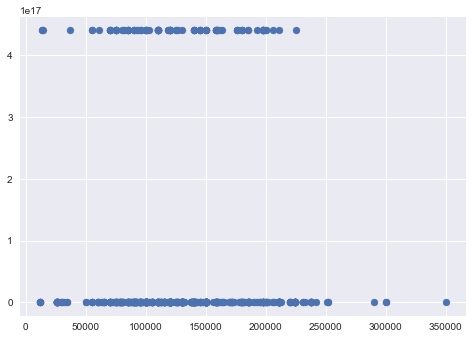

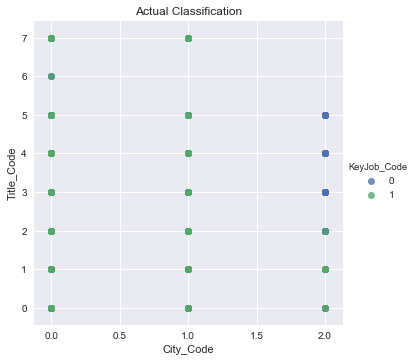

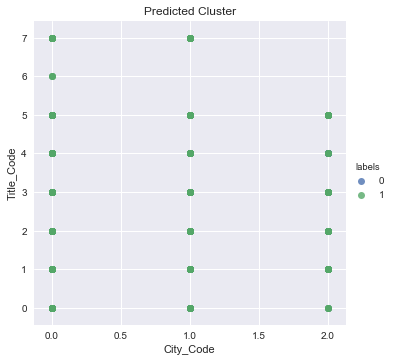

In [917]:
# Checking how the predicted value differs from the original value.
# The silhouette score is not great. But just checking it up
data_job2 = data_job[:]
data_job2['labels'] = labels_2

sns.lmplot(x='City_Code', y='Title_Code', data=data_job2, hue='KeyJob_Code', fit_reg=False)
plt.title('Actual Classification')
plt.show()

sns.lmplot(x='City_Code', y='Title_Code', data=data_job2, hue='labels',fit_reg=False)
plt.title('Predicted Cluster')
plt.show()

- The Kmeans clustering was not a good idea. Looking at the predicted distributions and the actual distributions, I would not choose this model.
- Next, let me see how logistic regression performs on this data.

#### Logistic regression mdoel

In [918]:
# drop the target - 'KeyJobCode', which is currently acting as a target (categorical)
X = data_job_dummies.drop('KeyJob_Code', axis = 1)
y = data_job_dummies.KeyJob_Code

X_cls = X[:]
y_cls = y.values

In [919]:
# Cross validate logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [920]:
cls_scores = cross_val_score(LogisticRegression(), X_cls, y_cls, cv=8)

print ('Classification/Logistic regression score:', cls_scores, np.mean(cls_scores))

logreg = LogisticRegression().fit(X_cls, y_cls)

Classification/Logistic regression score: [ 0.84225352  0.86197183  0.8700565   0.87288136  0.86402266  0.8101983
  0.87818697  0.84135977] 0.855116363825


- The logistic regression score is pretty good. But is it because I've used the data set? Can I split it into train and test set?
- Next, The aim is to find features that contribute to identify the different classification groups. I will try using the Grid Search CV for the  Decision tree classifier

####  Grid serach on Decision tree classifier

In [921]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [922]:
# Setting up the parameters for Gridsearch CV
dtc_params = {
    'max_depth':[4,5],
    'max_features':[None,2,3,4,5],
    'min_samples_split':[2,3,4,30]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [923]:
dtc_gs.fit(X_cls, y_cls)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 5], 'max_features': [None, 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [924]:
dtc_best = dtc_gs.best_estimator_
print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

{'max_depth': 4, 'max_features': None, 'min_samples_split': 3}
0.883038869258


In [925]:
# Get the features with the most importance from the GridSearch CV on the Decision Tree classifier
fi = pd.DataFrame({
        'feature':X_cls.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi = fi[fi['importance'] > 0]
fi

,feature,importance
318,data science,0.398249
299,data analyst,0.384582
184,business intelligence,0.087151
300,data analytics,0.049758
316,data reporting,0.031736
303,data driven,0.019386
609,market leader,0.008391
177,business data,0.006803
227,cbd location,0.005765
0,Title_Code_1,0.003923


In [926]:
fi.feature.unique()

array(['data science', 'data analyst', 'business intelligence',
       'data analytics', 'data reporting', 'data driven', 'market leader',
       'business data', 'cbd location', 'Title_Code_1', 'best practices',
       'permanent time'], dtype=object)

#### It couldnt be more obvious than this! 
- The feature that makes data scientists stand out from the others is 'data scientist', 'analytics data', 'written communication skills', 'user experience', 'communication skills written', 'business value','business partnering.

### D. What features are important for distinguishing junior vs. senior positions?
- Here I will be using the Title_Code feature tthat classifies around 7 levels of positions to identify the clusters. 
- I am scoping it further by using it as multiple classification than a binary one!



In [927]:
# Copying my dataframe with the all the scraped jobs. Here it doesnt matter if there is a valid salary or not.
data_job = data[:]

In [928]:
data_job.head()

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary
0,3,0,0,0,0,2,1,Experience with Hadoop & Spark and related clo...,0.0
1,5,0,0,0,0,0,1,I am currently looking for a Senior Manager o...,180000.0
2,7,0,0,0,0,2,1,We are looking for a Head of Data Science Mach...,0.0
3,7,0,0,0,0,2,1,A unique Career opportunity along with an exce...,0.0
4,7,0,0,1,0,2,1,Our Company Tabcorp is one of the few integrat...,0.0


In [929]:
# As a matter of fact, I could drop salary and try to figure out other 
# features that distinguish Data Scientists from other jobs.
data_job.drop('Salary', axis = 1, inplace = True)

In [930]:
# Convert the categorical variables to dummies to proceed with linear regression
data_job_dummies = pd.get_dummies(data_job, drop_first = True, columns = ['KeyJob_Code', 'City_Code', 'Region_Code', 'Classif_Code',
       'WorkType_Code', 'Adv_Code'])

In [931]:
data_job_dummies.head(2)

,Title_Code,JobDescript,KeyJob_Code_1,City_Code_1,City_Code_2,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Classif_Code_1,Classif_Code_2,Classif_Code_3,Classif_Code_4,Classif_Code_5,Classif_Code_6,Classif_Code_7,WorkType_Code_1,WorkType_Code_2,Adv_Code_1,Adv_Code_2
0,3,Experience with Hadoop & Spark and related clo...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,5,I am currently looking for a Senior Manager o...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [932]:
from sklearn.feature_extraction.text import CountVectorizer

In [933]:
# Join all the Job Titles
all_text = [text for text in data_job_dummies['JobDescript']]

# Use Count vectorizer to get the  most used names in titles
vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,
                             preprocessor = None,stop_words = 'english',max_features = 1000, ngram_range = (2,3)) 

# Fit the titles to the model
train_data_features = vectorizer.fit_transform(all_text)

# Get the words and the count from the model
job_desc_words = pd.DataFrame(vectorizer.transform(all_text).todense(), columns=vectorizer.get_feature_names())

# Pick the top 40 to create the job title category
job_desc_words.sum().nlargest(1000)
job_desc_words.head()

,10 years,12 month,12 months,400 words,ability analyse,ability build,ability communicate,ability deliver,ability develop,ability engage,ability influence,ability manage,ability work,ability work independently,able demonstrate,able work,accc aer,accc aer responsibilities,accc aers,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist legal,acceptance criteria,acceptance testing,account management,accounting related,act 2010,actionable insights,ad hoc,add value,advanced analytics,advanced excel,advanced excel skills,advice range,aer board,aer called,agile delivery,agile development,agile environment,agile experience,agile methodology,agile scrum,agile waterfall,alternatively confidential,analyse assess,analyse assess distil,analyse business,analysis business,analysis data,analysis design,analysis documentation,analysis experience,analysis reporting,analysis skills,analyst experience,analyst join,analyst join team,analyst responsible,analyst role,analyst strong,analyst work,analytical problem,analytical problem solving,analytical skills,analytical skills ability,analytics data,analytics information,analytics reporting,analytics team,application development,application support,applications close,apply button,apply button information,apply click,apply click apply,apply contact,apply directly,apply forward,apply job,apply link,apply online,apply online click,apply online using,apply position,apply role,apply send,apply today,appropriate link,areas business,asia pacific,assess distil,assess distil key,assessing reviewing mergers,asset management,asx listed,australia leading,australia new,australia new zealand,australian economy,australias largest,australias leading,award winning,awareness influence,awareness influence business,bachelor degree,bachelors degree,banking financial,based information,based melbourne,based sydney,based sydney cbd,best practice,best practices,bi analytics,bi reporting,bi tools,big data,big data analytics,body responsible,body responsible regulating,brand new,broad range,build maintain,build organisational,build organisational capability,build relationships,business acumen,business analysis,business analysis experience,business analyst,business analyst experience,business analyst join,business analyst role,business analyst strong,business analyst work,business analysts,business areas,business case,business cases,business change,business data,business decisions,business development,business environment,business functional,business improvement,business information,business intelligence,business intelligence analyst,business intelligence analytics,business intelligence data,business intelligence tools,business needs,business objectives,business operations,business outcomes,business partnering,business partners,business performance,business problems,business process,business process improvement,business process mapping,business process modelling,business processes,business related,business requirements,business requirements functional,business role,business rules,business solutions,business stakeholders,business systems,business technical,business technology,business transformation,business unit,business units,business users,business value,button information,button information opportunities,ca cpa,candidates contacted,candidates strong,capability provide,career development,career progression,case development,cbd location,change management,changes market,changes prepare,changes prepare correspondence,click apply,click apply button,clicking apply,clicking apply button,client leading,client looking,client seeking,clients business,closely business,com au,com company,commerce accounting,commerce accounting related,commercial acumen,commercial experience,commonwealth statutory,commonwealth statutory authority,communication interpersonal,communication interpersonal skills,communication skills,communication skills ability,communication skills experience,communication skills strong,communicat

In [934]:
job_desc_words.sum().nlargest(1000)

business analyst                         1514
business intelligence                     962
experience working                        894
communication skills                      864
business requirements                     680
years experience                          611
com au                                    582
skills experience                         556
business analysis                         528
business process                          472
high level                                461
skills ability                            460
problem solving                           459
ability work                              410
click apply                               404
end end                                   375
apply button                              369
data analysis                             362
project management                        361
financial services                        356
confidential discussion                   334
data analytics                    

In [935]:
print(job_desc_words.shape)
data_job_dummies.shape

(2830, 1000)


(2830, 34)

In [936]:
print(job_desc_words.shape)
data_job_dummies.shape

(2830, 1000)


(2830, 34)

In [937]:
# Create a concatenated dataframe with the Job data and the m,
data_job_dummies = pd.concat([data_job_dummies, job_desc_words], axis=1)
data_job_dummies.shape
# data_w_text.head()

(2830, 1034)

In [938]:
data_job_dummies.head()
data_job_dummies.drop('JobDescript', axis = 1, inplace = True)

In [939]:
data_job_dummies.columns

Index(['Title_Code', 'KeyJob_Code_1', 'City_Code_1', 'City_Code_2',
       'Region_Code_1', 'Region_Code_2', 'Region_Code_3', 'Region_Code_4',
       'Region_Code_5', 'Region_Code_6',
       ...
       'xad xad', 'xad xad xad', 'years business', 'years business analysis',
       'years experience', 'years experience business',
       'years experience working', 'youll need', 'youll need succeed',
       'youre interested'],
      dtype='object', length=1033)

### KNN Classification model

In [988]:
# drop the target - 'KeyJobCode', which is currently acting as a target (categorical)
X = data_job_dummies.drop('Title_Code', axis = 1)
y = data_job_dummies.Title_Code

In [989]:
X.head()

,KeyJob_Code_1,City_Code_1,City_Code_2,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Region_Code_7,Region_Code_8,Region_Code_9,Region_Code_10,Region_Code_11,Region_Code_12,Region_Code_13,Region_Code_14,Region_Code_15,Region_Code_16,Region_Code_17,Region_Code_18,Classif_Code_1,Classif_Code_2,Classif_Code_3,Classif_Code_4,Classif_Code_5,Classif_Code_6,Classif_Code_7,WorkType_Code_1,WorkType_Code_2,Adv_Code_1,Adv_Code_2,10 years,12 month,12 months,400 words,ability analyse,ability build,ability communicate,ability deliver,ability develop,ability engage,ability influence,ability manage,ability work,ability work independently,able demonstrate,able work,accc aer,accc aer responsibilities,accc aers,accc gov,accc gov au,accc independent,accc independent commonwealth,accc specialist legal,acceptance criteria,acceptance testing,account management,accounting related,act 2010,actionable insights,ad hoc,add value,advanced analytics,advanced excel,advanced excel skills,advice range,aer board,aer called,agile delivery,agile development,agile environment,agile experience,agile methodology,agile scrum,agile waterfall,alternatively confidential,analyse assess,analyse assess distil,analyse business,analysis business,analysis data,analysis design,analysis documentation,analysis experience,analysis reporting,analysis skills,analyst experience,analyst join,analyst join team,analyst responsible,analyst role,analyst strong,analyst work,analytical problem,analytical problem solving,analytical skills,analytical skills ability,analytics data,analytics information,analytics reporting,analytics team,application development,application support,applications close,apply button,apply button information,apply click,apply click apply,apply contact,apply directly,apply forward,apply job,apply link,apply online,apply online click,apply online using,apply position,apply role,apply send,apply today,appropriate link,areas business,asia pacific,assess distil,assess distil key,assessing reviewing mergers,asset management,asx listed,australia leading,australia new,australia new zealand,australian economy,australias largest,australias leading,award winning,awareness influence,awareness influence business,bachelor degree,bachelors degree,banking financial,based information,based melbourne,based sydney,based sydney cbd,best practice,best practices,bi analytics,bi reporting,bi tools,big data,big data analytics,body responsible,body responsible regulating,brand new,broad range,build maintain,build organisational,build organisational capability,build relationships,business acumen,business analysis,business analysis experience,business analyst,business analyst experience,business analyst join,business analyst role,business analyst strong,business analyst work,business analysts,business areas,business case,business cases,business change,business data,business decisions,business development,business environment,business functional,business improvement,business information,business intelligence,business intelligence analyst,business intelligence analytics,business intelligence data,business intelligence tools,business needs,business objectives,business operations,business outcomes,business partnering,business partners,business performance,business problems,business process,business process improvement,business process mapping,business process modelling,business processes,business related,business requirements,business requirements functional,business role,business rules,business solutions,business stakeholders,business systems,business technical,business technology,business transformation,business unit,business units,business users,business value,button information,button information opportunities,ca cpa,candidates contacted,candidates strong,capability provide,career development,career progression,case development,cbd location,change management,changes market,changes prepare,changes prepare correspondence,click apply,click apply button,clic

In [990]:
# calculate the baseline accuracy:
y.value_counts()/y.sum()

1    0.340046
2    0.074361
3    0.049961
5    0.042215
4    0.019752
0    0.011425
7    0.009682
6    0.000581
Name: Title_Code, dtype: float64

In [991]:
from sklearn.neighbors import KNeighborsClassifier

In [992]:
# make an instance of a KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# fit on the unstandardized data:
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [993]:
# Evaluate the accuracy of the model

# predict the response values for the observations in X ("test the model")
# store the predicted response values
y_pred_class = knn.predict(X)

In [994]:
# compute classification accuracy
from sklearn import metrics

In [995]:
print (metrics.accuracy_score(y, y_pred_class))

0.976325088339


- The accuracy is almost like its overfitting.
- Lets try a test-train split
    - Create a 50-50 train-test-split of your target and predictors

In [996]:
from sklearn.model_selection import train_test_split

# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size=0.5)

# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print (metrics.accuracy_score(y_test, y_pred_class))

0.601413427562


In [997]:
# Evaluate the test accuracy
knn = KNeighborsClassifier(n_neighbors=X_train.shape[0])
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print (metrics.accuracy_score(y_test, y_pred_class))

0.624734982332


In [958]:
### Fit the KNN model

In [998]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [1011]:
folds = 5
max_neighbors = np.floor(X.shape[0] - X.shape[0]/5.)
print(max_neighbors)
# That is a lot of neighbours to iterate and check. I will check neighbours from 45 - 50
max_neighbors_list = [20, 50, 100, 150, 200]

2264.0


In [1012]:
# plot test accuracy by number of neighbors:
test_acc = []
for i in max_neighbors_list:
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    test_acc.append(knn.score(X_test, y_test))

20
50
100
150
200


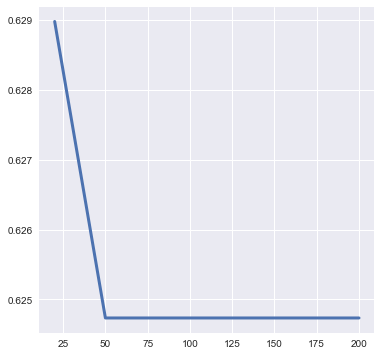

In [1018]:
# Check the difference between standardized and normal predictors
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(max_neighbors_list, test_acc, lw=3.)
# ax.plot(range(45, int(max_neighbors)), test_acc_std, lw=3., color='darkred')
plt.show()

- The Scores vary in avery small amount when using different neighbours for KNN. Apart from that the score of the model is not bad.

- Can I perform Feature selection on a KNN Model?
    - NO!

### E. Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?
- Here I will be using the Classif_Code feature that differentiates IT industry from others
Classif_Code = , IT else, Others

In [1082]:
# Copying my dataframe with the all the scraped jobs. Here it doesnt matter if there is a valid salary or not.
data_job = data[:]

In [1083]:
data_job.Classif_Code.value_counts()

0    1987
2     335
7     195
3     138
1      65
4      63
5      28
6      19
Name: Classif_Code, dtype: int64

In [1084]:
data_job['Classif_Code'] = [1 if code == 0 else 0 for code in data_job['Classif_Code']]

In [1087]:
data_job.head()
# data_job.Classif_Code.value_counts()

,Title_Code,City_Code,Region_Code,Classif_Code,WorkType_Code,Adv_Code,KeyJob_Code,JobDescript,Salary
0,3,0,0,1,0,2,1,Experience with Hadoop & Spark and related clo...,0.0
1,5,0,0,1,0,0,1,I am currently looking for a Senior Manager o...,180000.0
2,7,0,0,1,0,2,1,We are looking for a Head of Data Science Mach...,0.0
3,7,0,0,1,0,2,1,A unique Career opportunity along with an exce...,0.0
4,7,0,0,0,0,2,1,Our Company Tabcorp is one of the few integrat...,0.0


In [1088]:
# Convert the categorical variables to dummies to proceed with linear regression
data_job = data_job[['JobDescript', 'Classif_Code']]

In [1089]:
data_job.head(2)

,JobDescript,Classif_Code
0,Experience with Hadoop & Spark and related clo...,1
1,I am currently looking for a Senior Manager o...,1


In [1090]:
# So .. we'll use np.sum() to convert it directly from the sparse matrix!
# This is enormously more memory-efficient ...
#   It only requires one int per column since summing across columns is the total word count.

def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [1091]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [1092]:
# These look pretty clean for a first step in anlaysis
cvt = CountVectorizer(stop_words='english', lowercase=True, strip_accents="unicode", ngram_range=(2,3))
X_all = cvt.fit_transform(data_job['JobDescript'])
columns  =  np.array(cvt.get_feature_names())

In [1093]:
freq_words = get_freq_words(X_all, columns)
freq_words

business analyst                    1514
business intelligence                962
experience working                   894
communication skills                 864
business requirements                680
years experience                     611
com au                               582
skills experience                    556
business analysis                    527
business process                     472
high level                           461
skills ability                       460
problem solving                      459
ability work                         410
click apply                          404
end end                              375
apply button                         369
data analysis                        362
project management                   361
financial services                   356
confidential discussion              334
demonstrated experience              325
data analytics                       325
business processes                   316
work closely    

#### Setup a test / train split of your data using any method you wis

In [1114]:
# Find our training size
training_size = int(data_job.shape[0] * .7)

# Randomly sample our training data
data_job_train = data_job.sample(n=training_size, replace=True)

# Capture the rest of the dataset that's not "training" using an inverse mask (rows NOT IN training dataframe)
mask = data_job.index.isin(data_job_train.index)
data_job_test = data_job[~mask]

# Should be (2762, 1963) = training / testing = 70/30
data_job_train.shape[0], data_job_test.shape[0]

(1980, 1409)

#### Setup a "Pipeline" to vectorize and use MultinomialNB classifier

In [1099]:
# MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(data_job_train['JobDescript'], data_job_train['Classif_Code'])
predicted = pipeline.predict(data_job['JobDescript'])
pipeline.score(data_job_test['JobDescript'], data_job_test['Classif_Code'])

0.73469387755102045

In [1101]:
#  Add predicted probabilities back to original dataframe
data_job['Predicted_Classif'] = predicted

In [1105]:
predicted = pipeline.predict(data_job_test['JobDescript'])
print (classification_report(data_job_test['Classif_Code'], predicted, target_names=["IT Industry", "Others"]))

             precision    recall  f1-score   support

IT Industry       0.95      0.13      0.24       432
     Others       0.72      1.00      0.84       989

avg / total       0.79      0.73      0.66      1421



In [1106]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

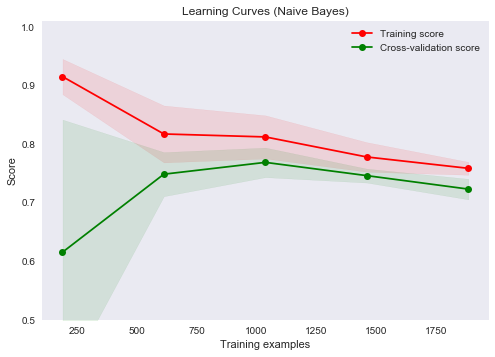

In [1107]:
# Pipeline variable can be replaced by your already established estimator
learning_plt = plot_learning_curve(pipeline, "Learning Curves (Naive Bayes)", data_job['JobDescript'], data_job['Classif_Code'], ylim=(0.5, 1.01), cv=3, n_jobs=4)

learning_plt.show()

In [1108]:
def multi_roc(y, probs):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        # probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [1109]:
from sklearn.metrics import roc_curve

def plot_roc(y, probs, threshmarkers=None):
    fpr, tpr, thresh = roc_curve(y, probs)

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, lw=2)
   
    plt.xlabel("False Positive Rate\n(1 - Specificity)")
    plt.ylabel("True Positive Rate\n(Sensitivity)")
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xticks(np.linspace(0, 1, 21), rotation=45)
    plt.yticks(np.linspace(0, 1, 21))
    plt.show()

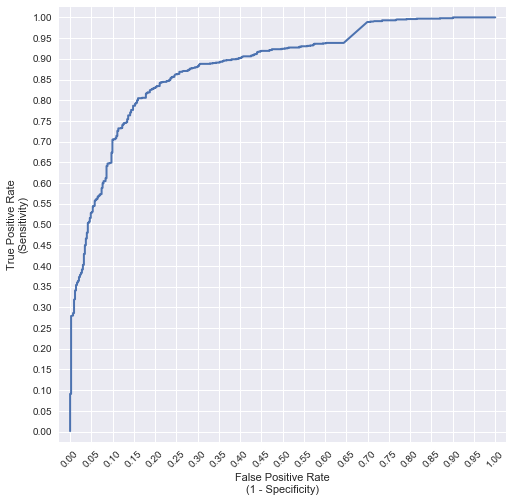

In [1110]:
predicted_proba = pipeline.predict_proba(data_job_test['JobDescript'])
plot_roc(data_job_test['Classif_Code'], predicted_proba[:, 1])

In [1112]:
# Check Baseline
data_job_train.Classif_Code.sum() * 1.0 / data_job_train.Classif_Code.count() * 1.0

0.69999999999999996

#### What is not right in the model?

In [1113]:
predicted = pipeline.predict(data_job['JobDescript'])

# Incorrectly classified
false_positives = data_job[(predicted == 1) & (data_job['Classif_Code'] == 0)]
true_negatives = data_job[(predicted == 0) & (data_job['Classif_Code'] == 1)]

# To view each comment in its entirety (Pandas has a set col width)
for comment in true_negatives['JobDescript']:
    print(comment)

At UNSW we pride ourselves on being a workplace where the best people come to do their best work. The Research Systems & Solutions Unit is one of four units reporting to the Executive Director (Research). The role of the Research Systems & Solutions Unit is to provide central systems support to a number of units within the Division of Research ensuring all systems are functional to business operations. By working closely with other units in the Division of Research the Unit provides solutions to improve business process and increase efficiency.  About the role The Business Data Analyst monitors the quality and presentation of data and continuously reviews processes within the Division of Research to ensure the delivery of high quality customer focussed services to the University. The Business Data Analyst assists the Team Leader Research Systems & Solutions by  You should systematically address the selection criteria listed within the position descriptionin your application . Please ap



**BONUS PROBLEM:**

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

Note that this requires framing the salary problem as a classification problem detecting low vs. high salary positions.

---


## Requirements

- Scrape and prepare your data using BeautifulSoup.

- **Create and compare at least two models for each section.**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing: Ridge, logistic regression, KNN, SVM, etc.
- A Jupyter Notebook with your analysis for a peer audience of data scientists. Make sure to clearly describe and label each section.
- A written report directed to your (non-technical!) Principal

 **Pro Tip:** You can find a good example report [here](https://www.dlsweb.rmit.edu.au/lsu/content/2_assessmenttasks/assess_tuts/reports_ll/report.pdf).

 **Pro Tip 2:** Scraping is one of the most fun, useful and interesting skills out there!  Don’t lose out by copying someone else.

___
### Useful Resources

- Read the docs for whatever technologies you use. Most of the time, there is a tutorial that you can follow, but not always, and learning to read documentation is crucial to your success!
- Document **everything**.
- Look up sample executive summaries online.
- [Advice on How to Write for a Non-Technical Audience](http://programmers.stackexchange.com/questions/11523/explaining-technical-things-to-non-technical-people)
- [Documentation for BeautifulSoup can be found here](http://www.crummy.com/software/BeautifulSoup/).

---

### Project Feedback + Evaluation

[See our DSI projects guide here.]()
